<a href="https://colab.research.google.com/github/IrinaArmstrong/CoNLL-2003_NER/blob/main/My_TestTaskNER_CRF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Тестовое задание 

   Ваша задача написать пайплайн для тренировки модели глубоко обучения (любую – **embeddings + LSTM, Bert** …) с использованием следующих инструментов: pytorch, sklearn, matplotlib – для решения задачи **NER** (извлечения сущностей).

   В качестве данных используется датасет **Conll2003** с четырьмя классами **Per, Org, Loc, Misc** в формате **Conll**.

   В тетрадке ниже заданы основные классы и функции для построения требуемого пайплайн, какие-то уже имплементированы, какие-то – нет. Их требуется доработать. Тем не менее если данный набор абстракций вам не подходит Вы можете написать свой пайплайн «с нуля», однако обоснованность у этих действий должна быть.

**Что оценивается в первую очередь:**
- Выбранная архитектура для решения задачи
- Выбранные предобученные веса 
- Полученные метрики

**Затем:**
- Глубина разведочного анализа
- Какая схема теггирования используется (**BIO, IO** или другие)
- Каким образом производится расчет метрик (потокенный отчет, отчет по точному совпадению спанов сущностей)

**С меньшим приоритетом:** 
- Скорость предобработки и постобработки данных 
- Стиль кода

# Environment

### Installations

In [77]:
! pip install --quiet transformers[torch] datasets seqeval torchmetrics==0.6.2
! pip install --quiet allennlp==1.2.1
!pip install torchtext==0.8.0 torch==1.7.1 pytorch-lightning==1.2.2

In [78]:
# ! pip install --quiet transformers[torch] datasets seqeval pytorch-lightning torchmetrics==0.6.2
# ! pip install --quiet allennlp==1.2.1

In [79]:
import torch
import transformers
import torchmetrics
import pytorch_lightning

print(f"torch: {torch.__version__}")
print(f"pytorch_lightning: {pytorch_lightning.__version__}")
print(f"transformers: {transformers.__version__}")
# print(torchmetrics.__version__)

torch: 1.7.1
pytorch_lightning: 1.2.2
transformers: 3.4.0


### Imports

In [6]:
# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="white", context="talk")
plt.style.use('default')
%matplotlib inline

In [7]:
import os
import re
import gc
import sys
import random
import datetime
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from collections import defaultdict, namedtuple, Counter

from typing import (List, Dict, Any, Tuple, Optional, Union)

In [8]:
# Networks
import transformers
import tokenizers

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Metrics
from seqeval.metrics import f1_score, accuracy_score, classification_report

In [9]:
import warnings
warnings.filterwarnings("ignore")

import logging
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)

### Mount drive (if in Colab)

In [80]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive',  force_remount=True)
    BASE_DIR = Path("/content/drive/MyDrive/DS Data&Notebooks/AutoNER-TestTask/")
    DATA_DIR = BASE_DIR / "data"
    OUTPUT_DIR = BASE_DIR / "outputs"
    MODEL_CHKP_DIR = BASE_DIR / "models"

Mounted at /content/drive


### Define Paths & Folders

In [81]:
if not IN_COLAB:
    BASE_DIR = Path().resolve()
    DATA_DIR = BASE_DIR / "data"
    OUTPUT_DIR = BASE_DIR / "outputs"
    MODEL_CHKP_DIR = BASE_DIR / "models"

if not DATA_DIR.exists():
    DATA_DIR.mkdir(exist_ok=True)
    logging.info(f"Data folder created at: {DATA_DIR}")

if not OUTPUT_DIR.exists():
    OUTPUT_DIR.mkdir(exist_ok=True)
    logging.info(f"Output folder created at: {OUTPUT_DIR}")

if not MODEL_CHKP_DIR.exists():
    MODEL_CHKP_DIR.mkdir(exist_ok=True)
    logging.info(f"Models checkpoints folder created at: {MODEL_CHKP_DIR}")

### Mount device

In [82]:
def acquire_device(device_type: str='cpu'):
    """ Init training device. """
    print(f"Training device provided: {device_type}")

    if device_type == 'cuda':
        if not torch.cuda.is_available():
            print(f"Device provided is CUDA, but it is available. Changing to CPU.")
            device = torch.device('cpu')
        else:
            device = torch.device(device_type)
            print(torch.cuda.get_device_name(0))
            print('Memory Usage, Allocated:', round(torch.cuda.memory_allocated(0) / 1024 ** 3, 1), 'GB')
            print('Memory Usage, Cached:', round(torch.cuda.memory_reserved(0) / 1024 ** 3, 1), 'GB')
    else:
        device = torch.device(device_type)
    print(f"Training device mounted: {device.type}")
    return device

def seed_everything(seed_value: int):
    random.seed(seed_value)  # Python
    np.random.seed(seed_value)  # cpu vars
    torch.manual_seed(seed_value)  # cpu  vars
    os.environ['PYTHONHASHSEED'] = str(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)  # for using CUDA backend
        torch.cuda.manual_seed_all(seed_value)  # gpu vars
        torch.backends.cudnn.deterministic = True  # get rid of nondeterminism
        torch.backends.cudnn.benchmark = True

# Set device
device = acquire_device("cuda")
print(device)
seed_everything(11)
# if device.type == 'cuda':
#     seed_everything(11)

Training device provided: cuda
Tesla K80
Memory Usage, Allocated: 0.8 GB
Memory Usage, Cached: 0.9 GB
Training device mounted: cuda
cuda


# Data

### Load datasets

In [13]:
!wget https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testa -P /content/data
!wget https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.train -P /content/data

!wget https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testb -P /content/data

--2022-01-31 13:43:20--  https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testa
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 827012 (808K) [text/plain]
Saving to: ‘/content/data/eng.testa’

eng.testa           100%[===================>] 807.63K  --.-KB/s    in 0.03s   

2022-01-31 13:43:20 (25.9 MB/s) - ‘/content/data/eng.testa’ saved [827012/827012]

--2022-01-31 13:43:20--  https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.train
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3

In [14]:
!head /content/data/eng.testb

-DOCSTART- -X- -X- O

SOCCER NN I-NP O
- : O O
JAPAN NNP I-NP I-LOC
GET VB I-VP O
LUCKY NNP I-NP O
WIN NNP I-NP O
, , O O
CHINA NNP I-NP I-PER


## Dataset Summary
The shared task of **CoNLL-2003** concerns language-independent named entity recognition. 

There are 4 types of named entities: 
* **persons**, 
* **locations**, 
* **organizations**, 
* **names of miscellaneous entities** that do not belong to the previous three groups.

The CoNLL-2003 shared task data files contain four columns separated by a single space. Each word has been put on a separate line and there is an empty line after each sentence. 

#### Columns:
1. **Token** - a single word,
2. **PoS** - a part-of-speech,
3. **SyncTag** - a syntactic chunk tag,
4. **NERTag** - the named entity tag

#### Other notes:
* Dataset uses **IOB1 tagging scheme**, where the `I- prefix` before a tag indicates that the tag is inside a chunk. An `O tag` indicates that a token belongs to no chunk. The `B- prefix` before a tag indicates that the tag is the beginning of a chunk that immediately follows another chunk without O tags between them. It is used only in that case: when a chunk comes after an O tag, the first token of the chunk takes the I- prefix. 
* `-DOCSTART-` - is a special line that acts as a boundary between two different documents.



In [15]:
if DATA_DIR.exists():
    all_files = list(DATA_DIR.glob("*.*"))
    print(f"In Dataset dir found {len(all_files)} files:")
    for fn in all_files:
        print(f"\t{fn.name}")

train_fn = DATA_DIR / "eng.train"
val_fn = DATA_DIR / "eng.testa"

In Dataset dir found 3 files:
	eng.testa
	eng.train
	eng.testb


### Read & Explore

In [16]:
class TextData:
    """ Representation of single sentence/text and it's attributes. """

    def __init__(self, tokens: List[str], 
                 ner_tags: List[str],
                 pos_tags: List[str] = None, 
                 sync_tags: List[str] = None) -> None:
        self.tokens = tokens
        self.ner_tags = ner_tags
        self.pos_tags = pos_tags
        self.sync_tags = sync_tags
        self.spans = None
    
    def __str__(self) -> str:
        s = f"Tokens: {self.tokens},\n"
        s += f"NER tags: {self.ner_tags},\n"
        s += f"Sync tags: {self.sync_tags},\n"
        s += f"POS tags: {self.pos_tags}."
        return s
    
    def set_spans(self, spans: List[List[int]]):
        """
        Initialize spans bondaries in the tokens sequence.
        Spans are `inclusive`.
        e.t. [start_i, end_i], not (start_i, end_i) !
        """
        self.spans = spans

In [83]:
def split_tag(span_tag: str):
    """
    Split span tag into IOBES prefix and chunk_type
    e.g. 
    B-PER -> (B, PER)
    O -> (O, None)
    """
    if span_tag == 'O':
        return ('O', None)
    return span_tag.split('-', maxsplit=1)

def _is_doc_start(line: str) -> bool:
    if line.strip().startswith("-DOCSTART-"):
        return True
    return False

def _is_divider(line: str) -> bool:
    empty_line = line.strip() == ''
    if empty_line:
        return True
    return False

def read_conllu_data(data_fn: str):
    dataset = []

    with open(str(data_fn), 'rt') as f:
        for is_divider, lines in itertools.groupby(f, _is_divider):
            lines = list(lines)
            if is_divider or not len(lines[0]):
                continue
            if _is_doc_start(lines[0]):
                continue
            # fields of data
            fields = [line.strip().split() for line in lines]
            # data as list: [[tokens], [pos_tags], [sync_tags], [ner_tags]]
            fields = [list(field) for field in zip(*fields)]  
            dataset.append(TextData(tokens=fields[0],
                                    pos_tags=fields[1],
                                    sync_tags=fields[2],
                                    ner_tags=fields[3]))
    return dataset

In [84]:
train_data = read_conllu_data(str(train_fn))
val_data = read_conllu_data(str(val_fn))

print(f"Train data contains: {len(train_data)} texts and total {sum([len(d.tokens) for d in train_data])} tokens")
print(f"Val data contains: {len(val_data)} texts and total {sum([len(d.tokens) for d in val_data])} tokens")

Train data contains: 14041 texts and total 203621 tokens
Val data contains: 3250 texts and total 51362 tokens


As we can see, there are approximately 17,000 sentences in the dataset, comprising more than 255 thousands words and tags. This corresponds to approximately ~15 words per text. 

## Explore & Examples

Let's have a look at texts, different NER/POS/Sync tags and their frequencies: 

In [85]:
for i, sent in enumerate(train_data):
    if i > 3:
        break
    print(f"\nSent#{i}:")
    print(train_data[i])


Sent#0:
Tokens: ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'],
NER tags: ['I-ORG', 'O', 'I-MISC', 'O', 'O', 'O', 'I-MISC', 'O', 'O'],
Sync tags: ['I-NP', 'I-VP', 'I-NP', 'I-NP', 'I-VP', 'I-VP', 'I-NP', 'I-NP', 'O'],
POS tags: ['NNP', 'VBZ', 'JJ', 'NN', 'TO', 'VB', 'JJ', 'NN', '.'].

Sent#1:
Tokens: ['Peter', 'Blackburn'],
NER tags: ['I-PER', 'I-PER'],
Sync tags: ['I-NP', 'I-NP'],
POS tags: ['NNP', 'NNP'].

Sent#2:
Tokens: ['BRUSSELS', '1996-08-22'],
NER tags: ['I-LOC', 'O'],
Sync tags: ['I-NP', 'I-NP'],
POS tags: ['NNP', 'CD'].

Sent#3:
Tokens: ['The', 'European', 'Commission', 'said', 'on', 'Thursday', 'it', 'disagreed', 'with', 'German', 'advice', 'to', 'consumers', 'to', 'shun', 'British', 'lamb', 'until', 'scientists', 'determine', 'whether', 'mad', 'cow', 'disease', 'can', 'be', 'transmitted', 'to', 'sheep', '.'],
NER tags: ['O', 'I-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'I-MISC', 'O', 'O', 'O', 'O', 'O', 'I-MISC', 'O', 'O', 'O', 'O', 'O', 'O'

#### Sentence lengths

In [18]:
train_sentences_lens = [len(sent.tokens) for sent in train_data]
val_sentences_lens = [len(sent.tokens) for sent in val_data]

INFO: NumExpr defaulting to 2 threads.


Train Dataset sentences length distributions:
count    14041.000000
mean        14.501887
std         11.602756
min          1.000000
25%          6.000000
50%         10.000000
75%         22.000000
max        113.000000
dtype: float64


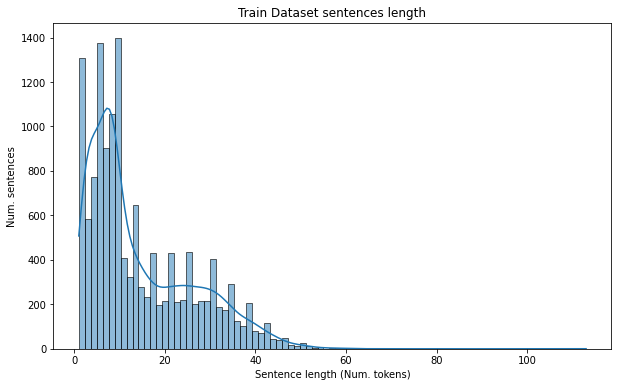

In [19]:
# On train data
plt.figure(figsize=(10, 6))
d = sns.histplot(data=train_sentences_lens, kde=True)
d.set_ylabel("Num. sentences")
d.set_xlabel("Sentence length (Num. tokens)")
_ = d.set_title("Train Dataset sentences length")\

print(f"Train Dataset sentences length distributions:")
print(pd.Series(train_sentences_lens).describe())

Validation Dataset sentences length distributions:
count    3250.000000
mean       15.803692
std        12.603389
min         1.000000
25%         7.000000
50%        11.000000
75%        24.000000
max       109.000000
dtype: float64


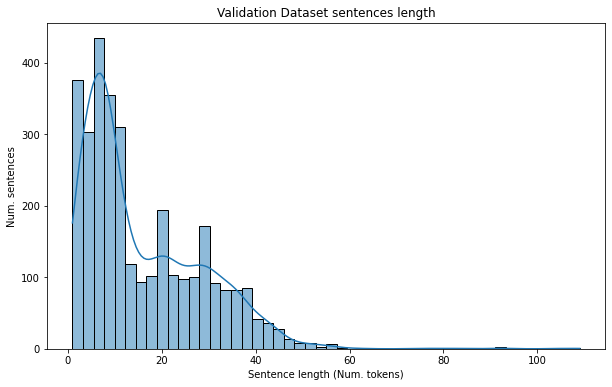

In [20]:
# On validation data
plt.figure(figsize=(10, 6))
d = sns.histplot(data=val_sentences_lens, kde=True)
d.set_ylabel("Num. sentences")
d.set_xlabel("Sentence length (Num. tokens)")
_ = d.set_title("Validation Dataset sentences length")\

print(f"Validation Dataset sentences length distributions:")
print(pd.Series(val_sentences_lens).describe())

**Findings**


*   Validation dataset's sentences are a bit more longer than the sentences in the training data at mean value. However this point is not very critical, cause difference is not very high: 14.5 vs. 15.5


#### POS Tags


In [21]:
# All POS tags existing in dataset
pos_tags = ['"', "''", '#', '$', '(', ')', ',', '.', ':', '``', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'NN|SYM', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB']

In [22]:
def pos_tags_distribution(text_data: List[TextData]) -> Dict[str, Any]:
    return Counter(list(itertools.chain.from_iterable([text.pos_tags for text in text_data]))).most_common()

In [23]:
# Calculate separately
train_pos_tags_dist = pd.DataFrame.from_records(pos_tags_distribution(train_data), 
                                                columns=['tag', 'cnt'])
val_pos_tags_dist = pd.DataFrame.from_records(pos_tags_distribution(val_data), 
                                              columns=['tag', 'cnt'])

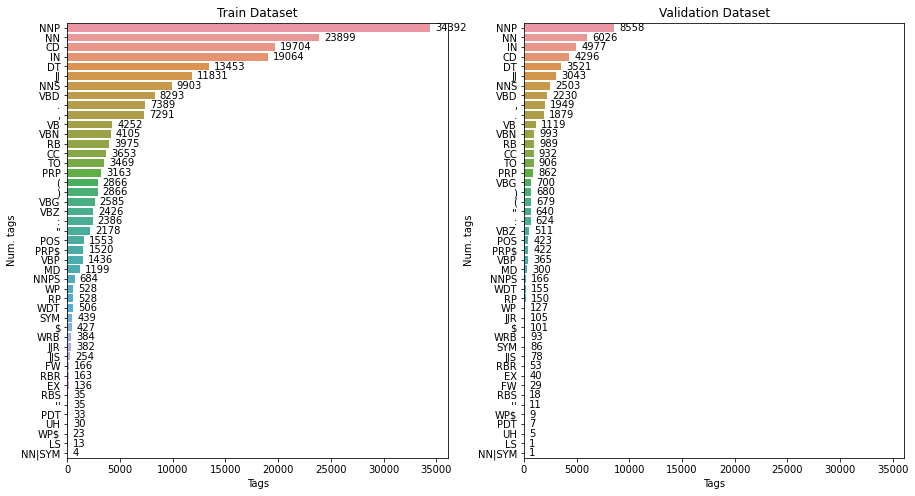

In [24]:
# Visualize
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15, 8))

axes[0].set_title('Train Dataset')
sns.barplot(data=train_pos_tags_dist, y="tag", x='cnt', ax=axes[0])
axes[0].set_ylabel("Num. tags")
axes[0].set_xlabel("Tags")

for p in axes[0].patches:
    axes[0].annotate("%d" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")

axes[1].set_title('Validation Dataset')
sns.barplot(data=val_pos_tags_dist, y="tag", x='cnt', ax=axes[1])
axes[1].set_ylabel("Num. tags")
axes[1].set_xlabel("Tags")

for p in axes[1].patches:
    axes[1].annotate("%d" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")

plt.show()

#### Synctactic Tags

In [25]:
def sync_tags_distribution(text_data: List[TextData]) -> Dict[str, Any]:
    tags_ = [split_tag(tag) for text in text_data for tag in text.sync_tags]
    return Counter([tag[0] if tag[1] is None else tag[1] for tag in tags_ ]).most_common()

In [26]:
# Calculate separately
train_sync_tags_dist = pd.DataFrame.from_records(sync_tags_distribution(train_data), 
                                                columns=['tag', 'cnt'])
val_sync_tags_dist = pd.DataFrame.from_records(sync_tags_distribution(val_data), 
                                              columns=['tag', 'cnt'])

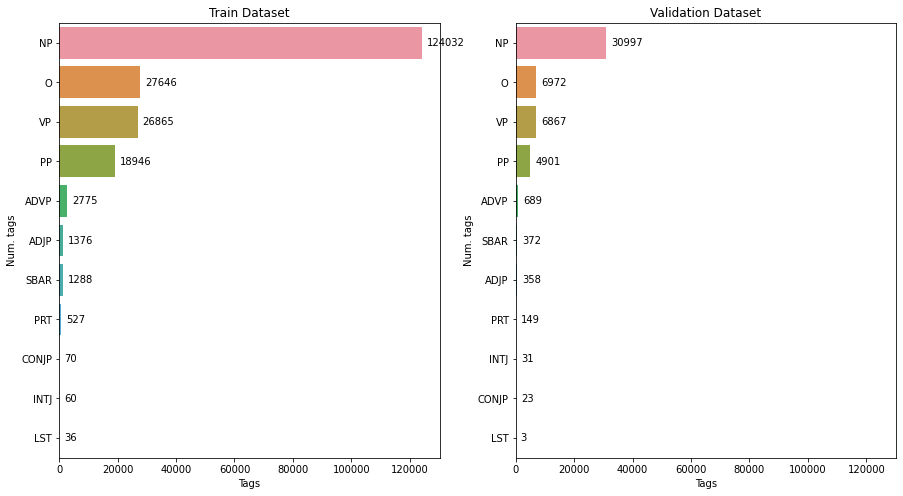

In [27]:
# Visualize
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15, 8))

axes[0].set_title('Train Dataset')
sns.barplot(data=train_sync_tags_dist, y="tag", x='cnt', ax=axes[0])
axes[0].set_ylabel("Num. tags")
axes[0].set_xlabel("Tags")

for p in axes[0].patches:
    axes[0].annotate("%d" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")

axes[1].set_title('Validation Dataset')
sns.barplot(data=val_sync_tags_dist, y="tag", x='cnt', ax=axes[1])
axes[1].set_ylabel("Num. tags")
axes[1].set_xlabel("Tags")

for p in axes[1].patches:
    axes[1].annotate("%d" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")

plt.show()

#### NER Tags

In [28]:
def ner_tags_distribution(text_data: List[TextData]) -> Dict[str, Any]:
    return Counter(list(itertools.chain.from_iterable([text.ner_tags for text in text_data]))).most_common()

def ner_tags_distribution_splitted(text_data: List[TextData]) -> Dict[str, Any]:
    tags_ = [split_tag(tag) for text in text_data for tag in text.ner_tags]
    return Counter([tag[0] if tag[1] is None else tag[1] for tag in tags_ ]).most_common()

In [29]:
# Calculate separately

# Tags with prefixes: B- and I-
train_ner_tags_dist = pd.DataFrame.from_records(ner_tags_distribution(train_data), 
                                                columns=['tag', 'cnt'])
val_ner_tags_dist = pd.DataFrame.from_records(ner_tags_distribution(val_data), 
                                              columns=['tag', 'cnt'])
# Tags without prefixes
train_ner_tags_spl_dist = pd.DataFrame.from_records(ner_tags_distribution_splitted(train_data), 
                                                columns=['tag', 'cnt'])
val_ner_tags_spl_dist = pd.DataFrame.from_records(ner_tags_distribution_splitted(val_data), 
                                              columns=['tag', 'cnt'])

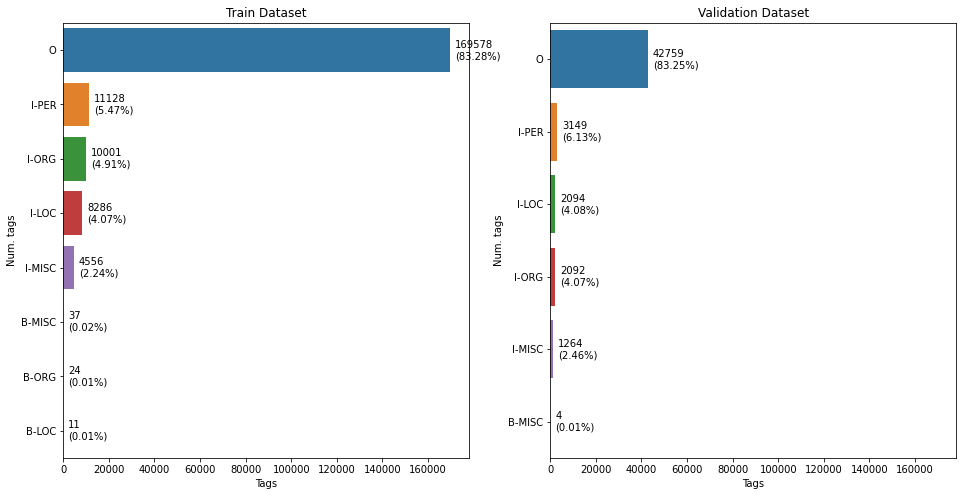

In [30]:
# Visualize with prefixes
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(16, 8))

axes[0].set_title('Train Dataset')
sns.barplot(data=train_ner_tags_dist, y="tag", x='cnt', ax=axes[0])
axes[0].set_ylabel("Num. tags")
axes[0].set_xlabel("Tags")

sum_train_tags = sum([p.get_width() for p in axes[0].patches])
for p in axes[0].patches:
    axes[0].annotate(f"{int(p.get_width())}\n({round(100*(p.get_width()/sum_train_tags), 2)}%)",
                     xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")

axes[1].set_title('Validation Dataset')
sns.barplot(data=val_ner_tags_dist, y="tag", x='cnt', ax=axes[1])
axes[1].set_ylabel("Num. tags")
axes[1].set_xlabel("Tags")

sum_val_tags = sum([p.get_width() for p in axes[1].patches])
for p in axes[1].patches:
    axes[1].annotate(f"{int(p.get_width())}\n({round(100*(p.get_width()/sum_val_tags), 2)}%)", 
                     xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")

plt.show()

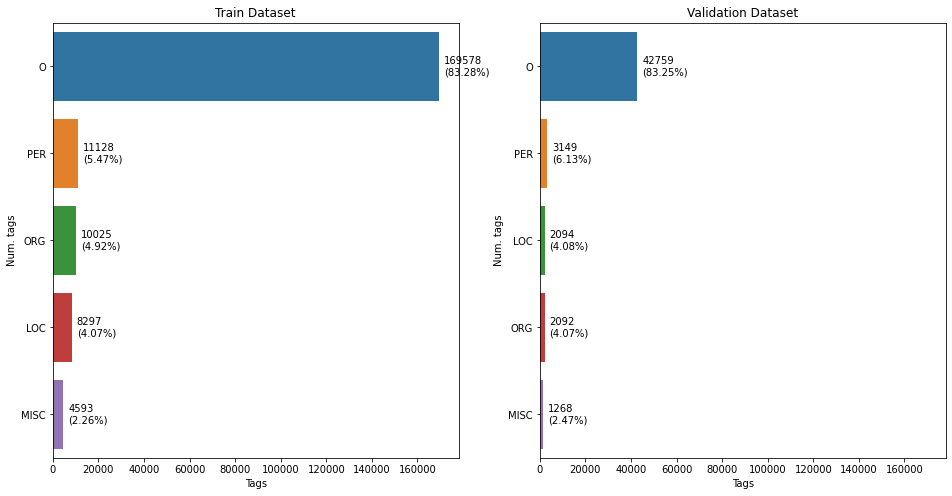

In [31]:
# Visualize without prefixes
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(16, 8))

axes[0].set_title('Train Dataset')
sns.barplot(data=train_ner_tags_spl_dist, y="tag", x='cnt', ax=axes[0])
axes[0].set_ylabel("Num. tags")
axes[0].set_xlabel("Tags")

sum_train_tags = sum([p.get_width() for p in axes[0].patches])
for p in axes[0].patches:
    axes[0].annotate(f"{int(p.get_width())}\n({round(100*(p.get_width()/sum_train_tags), 2)}%)",
                     xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")

axes[1].set_title('Validation Dataset')
sns.barplot(data=val_ner_tags_spl_dist, y="tag", x='cnt', ax=axes[1])
axes[1].set_ylabel("Num. tags")
axes[1].set_xlabel("Tags")

sum_val_tags = sum([p.get_width() for p in axes[1].patches])
for p in axes[1].patches:
    axes[1].annotate(f"{int(p.get_width())}\n({round(100*(p.get_width()/sum_val_tags), 2)}%)", 
                     xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")

plt.show()

In [32]:
ner_tags_dist = train_ner_tags_spl_dist.merge(val_ner_tags_spl_dist, 
                                              how='outer', on='tag', 
                                              suffixes=['_train', '_val']).fillna(0)
ner_tags_dist['cnt'] = (ner_tags_dist['cnt_train'] + ner_tags_dist['cnt_val']).astype('int')
entities_types = ner_tags_dist['tag'].unique().tolist()
print(f"No-prefixes entities types: {entities_types}")

ner_tags_dist = train_ner_tags_dist.merge(val_ner_tags_dist, 
                                          how='outer', on='tag', 
                                          suffixes=['_train', '_val']).fillna(0)
ner_tags_dist['cnt'] = (ner_tags_dist['cnt_train'] + ner_tags_dist['cnt_val']).astype('int')
pref_entities_types = ner_tags_dist['tag'].unique().tolist()
print(f"With-prefixes entities types: {pref_entities_types}")

No-prefixes entities types: ['O', 'PER', 'ORG', 'LOC', 'MISC']
With-prefixes entities types: ['O', 'I-PER', 'I-ORG', 'I-LOC', 'I-MISC', 'B-MISC', 'B-ORG', 'B-LOC']


**Findings**

*   There is **a strong imbalance of classes**, and it does not make sense to take into account the OUT label at all in quality estimation of the model.
*   Another option is to augment our training dataset with new samples for NE classes: ``` [`PER`, `ORG`, `LOC`, `MISK`] ```

#### Spans of Named Entities

Named Entities  in texts are usually represented as contiguous spans of tokens, so let's discover **lengths distribution** of them and **average number of spans** in each sentence.

Let's select them and print some examples of them: 

In [33]:
n_examples = 5
entities_examples = dict.fromkeys([t for t in entities_types if t != "O"])

for ent_name in [t for t in entities_types if t != "O"]:
    n_found = 0
    found_spans = []
    for d in train_data:
        if ent_name in np.unique([tag.split("-")[-1] for tag in d.ner_tags]):
            span_tokens = []
            start_i = d.ner_tags.index(f"I-{ent_name}")  # for IOB1 tagging
            for i, tag in enumerate(d.ner_tags[start_i:]):
                if tag in ["O", "B"]:  # for IOB1 tagging
                    break
                span_tokens.append(d.tokens[start_i+i])
            found_spans.append(" ".join(span_tokens))
            n_found += 1
            if n_found > n_examples:
                break
    entities_examples[ent_name] = found_spans

for ent, exs in entities_examples.items():
    print(f"{ent}:")
    for e in exs:
        print(f"\t{e}")

PER:
	Peter Blackburn
	Werner Zwingmann
	Nikolaus van der Pas
	Franz Fischler
	Fischler
	Fischler
ORG:
	EU
	European Commission
	European Union
	Commission
	European Union
	EU
LOC:
	BRUSSELS
	Germany
	Britain
	France
	Europe
	Germany
MISC:
	German
	German
	EU-wide
	Spanish
	BSE
	British


In [34]:
def select_spans_IOB1(text_data: List[TextData]) -> List[List[int]]:
    all_spans = []
    
    # iterate over the texts
    for d in text_data:
        spans = []
        cur_tag = None
        cur_start = None
        # iterate over the tags
        for tag_i, tag in enumerate(d.ner_tags):
            tag_pos = tag[0]  # tag `position`
            if tag_pos == 'B':
                # save previous span, if exists
                if cur_tag is not None:
                    spans.append([cur_tag, cur_start, tag_i - 1])
                cur_start = tag_i  # new tag starts
                cur_tag = tag[2:]  # tag `name`
            elif tag_pos == 'I':
                # new tag starts
                if cur_tag is None: 
                    cur_start = tag_i  # new tag starts
                    cur_tag = tag[2:]  # tag `name`
            elif tag_pos == 'O':
                # span finished, saving
                if cur_tag is not None:
                    spans.append([cur_tag, cur_start, tag_i - 1])
                    cur_tag = None
                    cur_start = None
        # save last span    
        if cur_tag is not None:
            spans.append([cur_tag, cur_start, tag_i + 1])

        # set to current sequence excluding tag type
        # d.set_spans([s[1:] for s in spans])
        all_spans.append(spans)

    return all_spans

def span_length(start_i: int, end_i: int) -> int:
    """ 
    Assumes inclusive span bondaries. 
    """
    return end_i - start_i + 1

In [35]:
# Retrieve spans of NE from train and val datasets
train_spans = select_spans_IOB1(train_data)
val_spans = select_spans_IOB1(val_data)

print(f"Train data contains: {sum([len(s) for s in train_spans])} NE spans.")
print(f"Val data contains: {sum([len(s) for s in val_spans])} NE spans.")

Train data contains: 23326 NE spans.
Val data contains: 5902 NE spans.


In [36]:
# Train spans
train_spans = pd.DataFrame.from_records(list(itertools.chain.from_iterable(train_spans)), 
                                        columns=['tag', 'start_i', 'end_i'])
train_spans['span_len'] = train_spans[['start_i', 'end_i']].apply(lambda x: span_length(x[0], x[1]), axis=1)

print("General span length distribution:")
print(train_spans['span_len'].describe())

print("\nBy Tags:")
train_spans.groupby(by='tag')['span_len'].describe()

General span length distribution:
count    23326.000000
mean         1.490225
std          0.739609
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         10.000000
Name: span_len, dtype: float64

By Tags:


,count,mean,std,min,25%,50%,75%,max
tag,,,,,,,,
LOC,7125.0,1.190737,0.480061,1.0,1.0,1.0,1.0,10.0
MISC,3398.0,1.439082,0.808202,1.0,1.0,1.0,2.0,7.0
ORG,6271.0,1.617605,0.942275,1.0,1.0,1.0,2.0,10.0
PER,6532.0,1.721219,0.584773,1.0,1.0,2.0,2.0,6.0


In [37]:
val_spans = pd.DataFrame.from_records(list(itertools.chain.from_iterable(val_spans)), 
                                        columns=['tag', 'start_i', 'end_i'])
val_spans['span_len'] = val_spans[['start_i', 'end_i']].apply(lambda x: span_length(x[0], x[1]), axis=1)

print("General span length distribution:")
print(val_spans['span_len'].describe())

print("\nBy Tags:")
val_spans.groupby(by='tag')['span_len'].describe()

General span length distribution:
count    5902.000000
mean        1.482379
std         0.743915
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        10.000000
Name: span_len, dtype: float64

By Tags:


,count,mean,std,min,25%,50%,75%,max
tag,,,,,,,,
LOC,1832.0,1.170306,0.433990,1.0,1.0,1.0,1.0,5.0
MISC,916.0,1.466157,0.805684,1.0,1.0,1.0,2.0,5.0
ORG,1325.0,1.575849,1.018569,1.0,1.0,1.0,2.0,10.0
PER,1829.0,1.735375,0.594431,1.0,1.0,2.0,2.0,7.0


**Findings**

*   The longest Named Entities are (as quite expected) are referring to names and surnames - `PER` tag.
*   Anyway, entities are on average less than 2 tokens, which means that they are mostly simple and do not contain nested Named Entities.

### Improvements & Processing

#### **Improvements**

**1. Tags convertion**

In original [dataset paper](https://aclanthology.org/W03-0419.pdf) authors says: ``` We assume that named entities are non-recursive and non-overlapping. ``` <br>
However then: ``` When a named
entity is embedded in another named entity, usually
only the top level entity has been annotated. ```

Anyway, entities are on average less than 2 tokens, which means that they are mostly simple and do not contain nested Named Entities.

But it is usually better to convert BIO1 tags of dataset to one of the following tagging schemas: 
- `IOB2` - is the same as the IOB format except that the B- tag is used in the beginning of every chunk.
- `BILOU` - B - 'beginning', I - 'inside', L - 'last', O - 'outside', U - 'unit' (sometimes called `BIOES`, with E - ending, S - singleton). This scheme allows nesting Named Entities.

**2. Minor tokens pre-processing**
* It is assumed, that for the NER task, *the information present in numerical digits does not help in predicting the entity*. So, I replace all the digits by 0. So, now the model can concentrate on more important alphabets.

#### Tagging scheme convertions

In [86]:
def is_span_end(prev_tag: str, tag: str):
    """
    Check if the previous span ended between the previous and current word
    e.g. 
    (B-PER, I-PER) -> False
    (B-LOC, O)  -> True
    Note: in case of contradicting tags, e.g. (B-PER, I-LOC)
    this is considered as (B-PER, B-LOC)
    """
    prefix1, tag_type1 = split_tag(prev_tag)
    prefix2, tag_type2 = split_tag(tag)

    if prefix1 == 'O':
        return False
    if prefix2 == 'O':
        return prefix1 != 'O'

    if tag_type1 != tag_type2:
        return True

    return prefix2 in ['B', 'S'] or prefix1 in ['E', 'S']

def is_span_start(prev_tag: str, tag: str):
    """
    Check if a new span started between the previous and current word.
    """
    prefix1, tag_type1 = split_tag(prev_tag)
    prefix2, tag_type2 = split_tag(tag)

    if prefix2 == 'O':
        return False
    if prefix1 == 'O':
        return prefix2 != 'O'

    if tag_type1 != tag_type2:
        return True

    return prefix2 in ['B', 'S'] or prefix1 in ['E', 'S']

def convert_to_IOB2(tags: List[str]) -> List[str]:
    """
    Makes a convertion from any other tagging scheme to IOB2.
    IOB2:
        - B = begin, 
        - I = inside but not the first, 
        - O = outside
    e.g. 
    John   lives in New   York  City  .
    B-PER  O     O  B-LOC I-LOC I-LOC O
    """
    tags = [tag.split("-")[-1] for tag in tags]

    curr_tag = None
    converted_tags = []
    for tag in tags:
        if (tag != 'O'):
            if curr_tag is None:
                converted_tags.append(f"B-{tag}")  # beginning
                curr_tag = tag
            else:
                converted_tags.append(f"I-{tag}")  # ended or yet another one
                curr_tag = tag
        else:
            converted_tags.append(tag)  # simply O
            curr_tag = None
    return converted_tags

In [87]:
# Example of convertion to IOB2
i = 3
print(f"IOB1:")
print(train_data[i].ner_tags)
print(f"IOB2:")
print(convert_to_IOB2(train_data[i].ner_tags))

IOB1:
['O', 'I-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'I-MISC', 'O', 'O', 'O', 'O', 'O', 'I-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
IOB2:
['O', 'B-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [88]:
# Convert full dataset to IOB2
for d in tqdm(train_data):
    d.ner_tags = convert_to_IOB2(d.ner_tags)

for d in tqdm(val_data):
    d.ner_tags = convert_to_IOB2(d.ner_tags)

print(f"\nConverted:")
print(train_data[3].ner_tags)

100%|██████████| 3250/3250 [00:00<00:00, 106928.73it/s]


Converted:
['O', 'B-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
def convert_to_IOBES(tags: List[str]) -> List[str]:
    """
    Makes a convertion from any other tagging scheme to IOBES.
    IOBES:
        - B = begin, 
        - E = end, 
        - S = singleton, 
        - I = inside but not the first or the last, 
        - O = outside
    e.g.
    John   lives in New   York  City  .
    S-PER  O     O  B-LOC I-LOC E-LOC O
    """
    converted_tags = []
    for i, tag in enumerate(tags):
        if tag == "O":
            converted_tags.append(tag)  # simply O
        elif split_tag(tag)[0] == 'B':
            # tag sequence start - no changes
            if (i + 1 != len(tags)) and (split_tag(tags[i + 1])[0] == 'I'):
                converted_tags.append(tag)
            else:
                # otherwise change Begin to Singleton
                converted_tags.append(tag.replace('B-', 'S-'))
        elif split_tag(tag)[0] == 'I':
            # tag sequence middle - no changes
            if (i + 1 < len(tags)) and (split_tag(tags[i + 1])[0] == 'I'):
                converted_tags.append(tag)
            else:
                # otherwise change Inside to Ending
                converted_tags.append(tag.replace('I-', 'E-'))
        else:
            print(f"Unrecognized tag: {tag}, skipping...")
    return converted_tags

In [ ]:
# Example of convertion to IOB2
i = 3
print(f"IOB2:")
print(train_data[i].ner_tags)
print(f"IOBES:")
print(convert_to_IOBES(train_data[i].ner_tags))

IOB2:
['O', 'B-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
IOBES:
['O', 'B-ORG', 'E-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'S-MISC', 'O', 'O', 'O', 'O', 'O', 'S-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
# Convert full dataset to IOBES
for d in tqdm(train_data):
    d.ner_tags = convert_to_IOBES(d.ner_tags)

for d in tqdm(val_data):
    d.ner_tags = convert_to_IOBES(d.ner_tags)

print(f"\nConverted:")
print(train_data[3].ner_tags)

100%|██████████| 3250/3250 [00:00<00:00, 119302.36it/s]


Converted:
['O', 'B-ORG', 'E-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'S-MISC', 'O', 'O', 'O', 'O', 'O', 'S-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


#### Pre-process tokens

In [41]:
# Count digits
n_digits = 0
n_tokens = 0
all_digits = []
for d in train_data:
    for token in d.tokens:
        if re.search("\d", token) is not None:
            n_digits += 1
            all_digits.append(token)
        n_tokens += 1

print(f"There are {n_digits} digits in training data (totally {n_tokens} tokens).")
print(f"Which id {100 * n_digits / n_tokens}%.\n")
print(f"Some of them:\n{all_digits[:10]}")

There are 19159 digits in training data (totally 203621 tokens).
Which id 9.409147386566218%.

Some of them:
['1996-08-22', '47,600', '4,275', '10', '17,000', '1996-08-22', '17,000', '10,925', '16,935', '1966']


## Preparing the Dataset

### **Transfromer-like models Dataset**

### Transfromers Tokenization problems

A key concept of NER with Transfromers is that the majority of such models relies on **WordPiece tokenization** / **BPE** / **SentencePiece tokenization**, rather than word tokenization. This means that the labels should also be defined at the wordpiece-level, rather than the word-level.

Example:

```
Initial word: 'infrequent'
Tag: 'B-count'
Tokenization result: [CLS, 'in', '##fr', '##e', '##quent', SEP]
```

**Aproaches**
1. To train the model on the tag labels for the first word piece token of a word (i.e. only label "Wash" with "b-gpe"). Assign -100 to the other subtokens from the same word.
This is what was done in the original BERT paper, see Github discussion [here](https://github.com/huggingface/transformers/issues/64#issuecomment-443703063).

```
Tag alignment result: [-100, 'B-count', -100, -100, -100, -100]
```

2. To propagate the original label of the word to all of its word pieces and let the model train on this. In that case, the model should be able to produce the correct labels for each individual wordpiece. This was done in [this NER tutorial with BERT](https://github.com/chambliss/Multilingual_NER/blob/master/python/utils/main_utils.py#L118).

```
Tag alignment result: [-100, 'B-count', 'B-count', 'B-count', 'B-count',-100]
```

3. To give the first wordpiece of each word the original word label, and then use the dummy label “X” for all subsequent subwords of that word. The important thing is that when calculating the loss (e.g., CELoss) and metrics (e.g., F1), this 'X' labels on the sub-tokens are not taken into account.

```
Tag alignment result: [-100, 'B-count', 'X', 'X', 'X', -100]
```

### Custom Dataset

Below, is defined a regular PyTorch dataset class, which:

* each sentence gets tokenized, 
* the special tokens that BERT/RoBERTa/GPT/other expects are added, 
* the tokens are padded or truncated based on the max length of the model, 
* the attention mask is created 
* the labels are created based on the mapping dictionaries
* transforms examples to PyTorch tensors

Word pieces that should be ignored have a label of -100 (which is the default `ignore_index` of PyTorch's [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)).

In [89]:
import datasets
from transformers import AutoTokenizer, AutoModel, AutoModelForTokenClassification, PreTrainedTokenizerFast

In [90]:
# Select all labels from dataset sorted by their frequencies
labels_counter = (Counter(list(itertools.chain.from_iterable([d.ner_tags for d in train_data]))) + 
                  Counter(list(itertools.chain.from_iterable([d.ner_tags for d in val_data])))).most_common()
labels_counter

[('O', 212337),
 ('B-LOC', 8946),
 ('B-PER', 8361),
 ('B-ORG', 7572),
 ('I-PER', 5916),
 ('I-ORG', 4545),
 ('B-MISC', 4275),
 ('I-MISC', 1586),
 ('I-LOC', 1445)]

In [91]:
def create_labels_mapping(unique_tags: List[str]):
    """
    Create a mapping (labels to indices / indices to labels) 
    from a set of unique labels to indices.
    Input items should be ordered by decreasing frequency, 
    so `O` would be at index = 0.
    return: id->label, label->id
    """
    ids_to_labels = {i: v for i, v in enumerate(unique_tags)}
    labels_to_ids = {v: k for k, v in ids_to_labels.items()}
    return ids_to_labels, labels_to_ids

ids_to_labels, labels_to_ids = create_labels_mapping([lc[0] for lc in labels_counter])
print(ids_to_labels)
print(labels_to_ids)

{0: 'O', 1: 'B-LOC', 2: 'B-PER', 3: 'B-ORG', 4: 'I-PER', 5: 'I-ORG', 6: 'B-MISC', 7: 'I-MISC', 8: 'I-LOC'}
{'O': 0, 'B-LOC': 1, 'B-PER': 2, 'B-ORG': 3, 'I-PER': 4, 'I-ORG': 5, 'B-MISC': 6, 'I-MISC': 7, 'I-LOC': 8}


In [92]:
class NERDataset(Dataset):

    available_schemas = ["IOB2", "BIOES"]

    def __init__(self, model_name: str,
                 pretrained_dir: Union[str, Path] = '', 
                 label_propagation_type: str = "first",
                 max_samples: int = -1, max_length: int = 50):
        """
        label_propagation_type - the selection option of algorithm 
                                for NER target label spreading 
                                with Tansformers subtoken tokenization style.
        Example: [CLS, 'in', '##fr', '##e', SEP]
        available: 'first' - [-100, 'B-TAG', 'X', 'X', -100], then 'X'-> -100
                   'all' - [-100, 'B-TAG', 'B-TAG', 'B-TAG', -100]
                   'begin-inside' - [-100, 'B-TAG', 'I-TAG', 'I-TAG', -100]
                                
        """
        self._max_samples = max_samples
        self._max_length = max_length

        if len(str(pretrained_dir)):
            if type(pretrained_dir) == str:
                pretrained_dir = Path(pretrained_dir)
            if not pretrained_dir.exists():
                print(f"Error: Directory with pre-trained model was not found by path: {pretrained_dir}")
                raise FileNotFoundError(f"Error: Directory with pre-trained model was not found by path: {pretrained_dir}")
            model_name = str(pretrained_dir / model_name)

        print(f"Loading {model_name} model's tokenizer...")
        self._tokenizer = AutoTokenizer.from_pretrained(model_name)
        self._tokenizer = PreTrainedTokenizerFast(__slow_tokenizer=self._tokenizer)
        self._label_propagation_type = label_propagation_type

        # get pad token 
        self.pad_token = self._tokenizer.special_tokens_map['pad_token']
        self.pad_token_id = self._tokenizer.get_vocab()[self.pad_token]
        self.sep_token = self._tokenizer.special_tokens_map['sep_token']

        self._tagging_scheme = None
        self._label2id = {}
        self._id2label = {}
        self._data = []

    def get_target_size(self):
        return len(set(self._label2id.values()))

    def get_target_labels(self):
        return self._label2id

    def __len__(self):
        return len(self._data)

    def __getitem__(self, item):
        return self._data[item]

    def set_dataset(self, data: List[TextData], 
                    labels_mapping: Dict[str, int],
                    tagging_scheme: str = "IOB2"):
        """
        Initialize and prepare dataset.
        """
        if tagging_scheme not in self.available_schemas:
            print(f"Error: Provided tagging scheme is not supported.")
            print(f"Choose one of the following: {self.available_schemas} and try again.")
            return self
        self._tagging_scheme = tagging_scheme

        # initialize labels mapping
        self._label2id = labels_mapping
        self._id2label = {v: k for k, v in self._label2id.items()}

        for text_i, text_data in enumerate(data):
            # `max_samples` set to -1 means no limitations on dataset length
            if (self._max_samples != -1) and (text_i >= self._max_samples):
                break
            parced_text, text_spans = self._parse_text(text_data)
            parced_text['spans'] = text_spans
            # self._data.append((parced_text['input_ids'], parced_text['attention_mask'], parced_text['ner_labels'], text_spans))
            self._data.append(parced_text)
        print(f"Finished data processing")
        return self

    def _parse_text(self, text_data: TextData):
        encoded_text = self._parse_ner_tokens(text_data.tokens, text_data.ner_tags)
        # select spans out of tags
        text_spans = self._extract_spans(encoded_text['ner_labels'])

        # At last turn everything into PyTorch tensors
        dtype = torch.long  # may be torch.float64
        encoded_text = {key: torch.as_tensor(val, dtype=dtype) for key, val in encoded_text.items()}
        encoded_text['ner_labels'] = encoded_text['ner_labels'].unsqueeze(0)
        return encoded_text, text_spans

    def _parse_ner_tokens(self, tokens: List[str], 
                          ner_tags: List[str]) -> transformers.BatchEncoding:
        """
        Tokenize and align tag labels for single text.
        """
        # `max_length` set to -1 means no limitations on sequence length
        text_encoding = self._tokenizer(tokens,
                                  is_split_into_words=True,
                                  truncation=True if self._max_length != -1 else False, 
                                  max_length=self._max_length if self._max_length != -1 else None,
                    return_offsets_mapping=True)

        # strip special tokens (bos and eos)
        # tokens_encoding = text_encoding['input_ids'][1:-1]

        # mapping special tokens to None and all other tokens to their respective word
        # word_ids = text_encoding.word_ids()
        word_ids = [text_encoding.token_to_word(t[0]) for t in 
                     enumerate(text_encoding.get('input_ids'))]
        if self._label_propagation_type == 'first':
            ner_prop_tags = self._propagate_tags_first(text_encoding['input_ids'],
                                                   word_ids,
                                                   ner_tags)
        elif self._label_propagation_type == 'all':
            ner_prop_tags = self._propagate_tags_all(text_encoding['input_ids'],
                                                   word_ids,
                                                   ner_tags)
        elif self._label_propagation_type == 'begin-inside':
            ner_prop_tags = self._propagate_tags_begin_inside(text_encoding['input_ids'],
                                                   word_ids,
                                                   ner_tags)
        else:
            print(f"Error: Unknown label_propagation_type: {self._label_propagation_type}")
            raise AttributeError(f"Error: Unknown label_propagation_type: {self._label_propagation_type}")

        text_encoding['ner_labels'] = ner_prop_tags

        # Re-map token mask so first part of splitted token = 1, others are set to 0
        tokens_mask = [1 if (offset[0] == 0) and (offset[1] != 0) else 0 
                     for offset in text_encoding['offset_mapping']]
        text_encoding['tokens_mask'] = tokens_mask
        return text_encoding

    def _propagate_tags_first(self, tokens_ids: List[int], 
                              words_ids: List[int], tags: List[int]):
        """
        Create token labels only for first word pieces of each tokenized word.
        """
        # encode tags to their's ids
        tags = [self._label2id[tag] for tag in tags]

        aligned_labels = []
        for w_id, w_rep in itertools.groupby(words_ids):
            if w_id is None:
                aligned_labels.append(self._label2id["O"])  #-100
            elif self._id2label[tags[w_id]] != "O":
                tag_ = [tags[w_id]] + [self._label2id["O"]] * (len(list(w_rep)) - 1)  #[-100] * (len(list(w_rep)) - 1)
                aligned_labels.extend(tag_)
            else:
                tag_ = [tags[w_id]] * len(list(w_rep))
                aligned_labels.extend(tag_)
        return aligned_labels

    def _propagate_tags_all(self, tokens_ids: List[int], 
                              words_ids: List[int], tags: List[int]):
        """
        Create token labels for all word pieces of each tokenized word.
        """
        # encode tags to their's ids
        tags = [self._label2id[tag] for tag in tags]
        return [-100 if i is None else tags[i] for i in words_ids]

    def _propagate_tags_begin_inside(self, tokens_ids: List[int], 
                                    words_ids: List[int], tags: List[int]):
        """
        Create token labels only for first word pieces of each tokenized word, 
        for other pieces propagate the same tag, but with 'I-' prefix.
        !!! Only for BIO tagging
        """
        aligned_labels = []
        for w_id, w_rep in itertools.groupby(words_ids):
            if w_id is None:
                aligned_labels.append(-100)
            elif tags[w_id].split("-")[0] == "B":
                tag_ = [tags[w_id]] + [f"I-{tags[w_id].split('-')[-1]}"] * (len(list(w_rep)) - 1)
                aligned_labels.extend(tag_)
            else:
                tag_ = [tags[w_id]] * len(list(w_rep))
                aligned_labels.extend(tag_)
        # encode tags to their's ids
        aligned_labels = [self._label2id[tag] if tag != -100 else -100
                          for tag in aligned_labels]
        return aligned_labels
    
    def _save_span(self, _cur_tag: Union[str, None], 
                   _cur_start: Union[int, None], 
                   _cur_id: Union[int, None], 
                   _gold_spans: Dict[Tuple[int, int], str]):
        """
        Utility function for span bondaries creation.
        """
        if _cur_start is None:
            return _gold_spans
        # inclusive start & end, accord with conll-coref settings
        _gold_spans[(_cur_start, _cur_id - 1)] = _cur_tag  
        return _gold_spans

    def _extract_spans(self, tags: List[Union[str, int]]):
        """
        Given a sequence of tag labels, return all token spans 
        within the sequence. Spans are `inclusive`.
        !!! Currently do NOT work with 'all' option in `label_propagation_type`
        !!! Only for BIO tagging
        """
        cur_tag = None
        cur_start = None
        gold_spans = {}

        if type(tags[0]) != str:
            # dencode tags ids to their str labels 
            tags = [self._id2label[tag] if tag != -100 else '-100'
                    for tag in tags]

         # iterate over the tags
        for tag_i, tag in enumerate(tags):
            tag_pos = tag[0]  # tag `position`
            if tag_pos == 'B':
                # save previous span, if exists
                gold_spans = self._save_span(cur_tag, cur_start, tag_i, gold_spans)
                cur_start = tag_i  # new tag starts
                cur_tag = tag[2:]  # tag `name`
            elif tag_pos == 'I':
                # do nothing
                pass
            elif tag_pos == 'O':
                # if (cur_tag != 'O') and (cur_tag is not None):
                    # span finished, saving
                gold_spans = self._save_span(cur_tag, cur_start, tag_i, gold_spans)
                cur_tag = 'O'
                cur_start = None
        # save last span    
        self._save_span(cur_tag, cur_start, tag_i + 1, gold_spans)
        return gold_spans

In [93]:
def collate_batch(batch, pad_token_id = 0, o_id = labels_to_ids['O']):

    # Unzip batch items
    tokens = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]
    tokens_masks = [b['tokens_mask'] for b in batch]
    tags = [b['ner_labels'] for b in batch] 
    spans = [b['spans'] for b in batch]

    # Pad tensors to single seq_len
    max_len = max([len(token) for token in tokens])
    token_tensor = torch.empty(size=(len(tokens), max_len), dtype=torch.long).fill_(pad_token_id)
    tag_tensor = torch.empty(size=(len(tokens), max_len), dtype=torch.long).fill_(o_id)
    mask_tensor = torch.zeros(size=(len(tokens), max_len), dtype=torch.int)
    tokens_mask_tensor = torch.zeros(size=(len(tokens), max_len), dtype=torch.int)

    for i in range(len(tokens)):
        tokens_ = tokens[i]
        seq_len = len(tokens_)

        token_tensor[i, :seq_len] = tokens_
        tag_tensor[i, :seq_len] = tags[i]
        mask_tensor[i, :seq_len] = masks[i]
        tokens_mask_tensor[i, :seq_len] = tokens_masks[i]
        
    return {"input_ids": token_tensor,
             "labels": tag_tensor,
             "attention_mask": mask_tensor,
             "tokens_mask": tokens_mask_tensor,
             "spans": spans}

# NER Experiments

In [94]:
import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

seed_everything(11)

Global seed set to 11
INFO: Global seed set to 11


11

### Metrics

The last thing to define for our `Trainer` is how to compute the metrics from the predictions. Here we will use:
  
*   **[`seqeval`](https://github.com/chakki-works/seqeval)** metric (which is commonly used to evaluate results on the CONLL dataset) via the Datasets library. This metric takes list of labels for the predictions and references.
*   **[`conlleval`](https://github.com/sighsmile/conlleval)** which can be used for measuring `the performance of a system within chunks (spans)` that has processed the CoNLL-2000 shared task data.

In [29]:
!wget https://raw.githubusercontent.com/sighsmile/conlleval/master/conlleval.py

from conlleval import evaluate
from datasets import load_metric

--2022-01-31 13:44:10--  https://raw.githubusercontent.com/sighsmile/conlleval/master/conlleval.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7502 (7.3K) [text/plain]
Saving to: ‘conlleval.py’

conlleval.py        100%[===================>]   7.33K  --.-KB/s    in 0s      

2022-01-31 13:44:10 (89.4 MB/s) - ‘conlleval.py’ saved [7502/7502]



In [30]:
metric = load_metric("seqeval")
metric

Downloading:   0%|          | 0.00/2.48k [00:00<?, ?B/s]

Metric(name: "seqeval", features: {'predictions': Sequence(feature=Value(dtype='string', id='label'), length=-1, id='sequence'), 'references': Sequence(feature=Value(dtype='string', id='label'), length=-1, id='sequence')}, usage: """
Produces labelling scores along with its sufficient statistics
from a source against one or more references.

Args:
    predictions: List of List of predicted labels (Estimated targets as returned by a tagger)
    references: List of List of reference labels (Ground truth (correct) target values)
    suffix: True if the IOB prefix is after type, False otherwise. default: False
    scheme: Specify target tagging scheme. Should be one of ["IOB1", "IOB2", "IOE1", "IOE2", "IOBES", "BILOU"].
        default: None
    mode: Whether to count correct entity labels with incorrect I/B tags as true positives or not.
        If you want to only count exact matches, pass mode="strict". default: None.
    sample_weight: Array-like of shape (n_samples,), weights for indi

## **BERT base model with CRF head**

Pretrained model on English language using a masked language modeling (MLM) objective. It was introduced in
[this paper](https://arxiv.org/abs/1810.04805) and first released in
[this repository](https://github.com/google-research/bert). 


**In summary:**



However, it is still interesting to estimate the impact of case on the final classification quality, therefore, we will **compare these two options.**


In [95]:
# from sklearn_crfsuite import CRF
from allennlp.modules import ConditionalRandomField
from allennlp.modules.conditional_random_field import allowed_transitions

In [96]:
# Select model checkpoint
# Options: 
# BERT base = {bert-base-cased, bert-base-uncased}

model_name = "bert-base-cased"

### Model Definition

In [97]:
class NER_Transformer_CRF(pl.LightningModule):
    def __init__(self, model_name: str,
                 pretrained_dir: Union[str, Path] = '',
                 train_data: List[TextData] = None, 
                 val_data: List[TextData] = None, pad_token_id: int = 0,
                 lr: float = 1e-5, dropout_rate: float = 0.1,
                 batch_size: int = 16, num_devices: int = 1,
                 label2id: Dict[str, int] = None, tagging_scheme: str = "IOB2",
                 stage: str = 'fit'):
        super(NER_Transformer_CRF, self).__init__()

        # Configure mappings & params
        self._id2label = {v: k for k, v in label2id.items()}
        self._label2id = label2id
        self._num_labels = len(self._id2label)
        self._tagging_scheme = tagging_scheme

        # Setup model
        # stage – either 'fit', 'validate', 'test', or 'predict'
        self._stage = stage
        self._model_name = model_name
        self._model = self.__setup_model(model_name, pretrained_dir)
        self._feedforward = torch.nn.Linear(in_features=self._model.config.hidden_size, 
                                            out_features=self._num_labels)
        self._dropout_layer = torch.nn.Dropout(dropout_rate)
        self._crf_layer = ConditionalRandomField(num_tags=self._num_labels,
                                                constraints=allowed_transitions(constraint_type='BIO', #  "BIO"
                                                                                labels=self._id2label))

        # Setup dataloaders
        self._train_data = train_data
        self._val_data = val_data
        self._batch_size = batch_size
        self._pad_token_id = pad_token_id

        # Setup training utils
        self._num_devices = num_devices
        self._base_lr = lr
        self._dropout_rate = dropout_rate

        # Setup metrics
        # Token-wise
        self._loss_fn = torch.nn.CrossEntropyLoss()
        self._seqeval_metric = datasets.load_metric("seqeval")
        # self._span_f1 = TODO

        # Save hyperparams
        self.save_hyperparameters('pad_token_id', 'model_name', 'tagging_scheme',
                                  'label2id', 'batch_size', 'lr', 'dropout_rate')

    def __setup_model(self, model_name: str,
                 pretrained_dir: Union[str, Path] = ''):
        """ 
        Load and setup models checkpoint form HuggingFace hub or local storage. 
        """
        if len(str(pretrained_dir)):
            if type(pretrained_dir) == str:
                pretrained_dir = Path(pretrained_dir)
            if not pretrained_dir.exists():
                logging.error(f"Error: Directory with pre-trained model was not found by path: {pretrained_dir}")
                raise FileNotFoundError(f"Error: Directory with pre-trained model was not found by path: {pretrained_dir}")
            model_name = str(pretrained_dir / model_name)
        # Load with addional config? 
        # i.e. config = AutoConfig.from_pretrained(model_name)
        logging.info(f"Loading model from {model_name}...")
        return AutoModel.from_pretrained(model_name, return_dict=True)
        
    def collate_batch(self, batch, pad_token_id = 0, o_id = labels_to_ids['O']):
        """
        The function to pass as the `collate_fn` argument to DataLoader.
        It is used to collate lists of samples into batches.
        """
        # Unzip batch items
        tokens = [b['input_ids'] for b in batch]
        masks = [b['attention_mask'] for b in batch]
        tokens_masks = [b['tokens_mask'] for b in batch]
        tags = [b['ner_labels'] for b in batch] 
        spans = [b['spans'] for b in batch]

        # Pad tensors to single seq_len
        max_len = max([len(token) for token in tokens])
        token_tensor = torch.empty(size=(len(tokens), max_len), dtype=torch.long).fill_(pad_token_id)
        tag_tensor = torch.empty(size=(len(tokens), max_len), dtype=torch.long).fill_(o_id)
        mask_tensor = torch.zeros(size=(len(tokens), max_len), dtype=torch.int)
        tokens_mask_tensor = torch.zeros(size=(len(tokens), max_len), dtype=torch.int)

        for i in range(len(tokens)):
            tokens_ = tokens[i]
            seq_len = len(tokens_)

            token_tensor[i, :seq_len] = tokens_
            tag_tensor[i, :seq_len] = tags[i]
            mask_tensor[i, :seq_len] = masks[i]
            tokens_mask_tensor[i, :seq_len] = tokens_masks[i]
            
        return {"input_ids": token_tensor,
                "labels": tag_tensor,
                "attention_mask": mask_tensor,
                "tokens_mask": tokens_mask_tensor,
                "spans": spans}

    def train_dataloader(self):
        """
        Implement one or more PyTorch DataLoaders for training.
        """ 
        if (self._stage == 'fit') and (self._train_data is None):
            logging.error(f"Training stage selected, but no training data passed!")
            raise AttributeError(f"Training stage selected, but no training data passed!")
            
        elif self._stage == 'fit':
            logging.info(f"Training stage selected.")
            logging.info(f"Creating training dataloader...")
            train_dataset = NERDataset(model_name=self._model_name,
                                       label_propagation_type='first')
            train_dataset = train_dataset.set_dataset(self._train_data,
                                                      self._label2id)
            train_loader = DataLoader(train_dataset, 
                                      batch_size=self._batch_size, 
                                      collate_fn=self.collate_batch,
                                      num_workers=0)
            logging.info(f"Training dataloader created.")
            return train_loader
        else:
            return None

    def val_dataloader(self):
        """
        Implement one or multiple PyTorch DataLoaders for validation.
        """
        if self._val_data is not None:
            logging.info(f"Creating validation dataloader...")
            val_dataset = NERDataset(model_name=self._model_name,
                                    label_propagation_type='first')
            val_dataset = val_dataset.set_dataset(self._val_data,
                                                    self._label2id)
            val_loader = DataLoader(val_dataset, 
                                    batch_size=self._batch_size, 
                                    collate_fn=self.collate_batch,
                                    num_workers=0)
            logging.info(f"Validation dataloader created.")
            return val_loader
        return None
        
    def configure_optimizers(self):
        """
        Create optimizer and learning rate scheduler.
        """
        optimizer = torch.optim.AdamW(self.parameters(), 
                                        lr=self._base_lr, 
                                        weight_decay=0.01)
        if self._stage == 'fit':
            # Calculate total steps
            train_batches = len(self._train_data) // (self._batch_size * self._num_devices)
            total_steps = 50 * train_batches
            warmup_steps = int(total_steps * 0.01)
            scheduler = transformers.get_linear_schedule_with_warmup(optimizer,
                                                                     num_warmup_steps=warmup_steps, 
                                                                     num_training_steps=total_steps)
            scheduler = {
                'scheduler': scheduler,  # REQUIRED: The scheduler instance
                'interval': 'step',
                'frequency': 1,
                "monitor": "val_loss",
                "strict": False
            }
            return [optimizer], [scheduler]
        return [optimizer], [None]

    def log_metrics(self, metrics_results: Dict[str, float], 
                    loss: float = 0.0, suffix: str = '', 
                    on_step: bool = False, on_epoch: bool = True):
        """
        To log metrics.
        metrics_results - dict of key = metric name, val = value of metric;
        """
        for key, val in metrics_results.items():
            if type(val) != dict:
                # overall metrics
                self.log(f"{suffix}_{key}", val, 
                        on_step=on_step,  # logs at this step
                        on_epoch=on_epoch,  # logs epoch accumulated metrics.
                        prog_bar=True,  # logs to the progress bar.
                        logger=True)  # logs to the logger
            else:
                # for each type of NE select f1 score
                for k, v in val.items():
                    if k == 'f1':
                        self.log(f"{suffix}_{key}_{k}", v, 
                            on_step=on_step,  # logs at this step
                            on_epoch=on_epoch,  # logs epoch accumulated metrics.
                            prog_bar=True,  # logs to the progress bar.
                            logger=True)  # logs to the logger
        # log loss
        self.log(f"{suffix}_loss", loss, on_step=on_step, 
                 on_epoch=on_epoch, prog_bar=True, logger=True)
        
    def compute_tagwise_metrics(self, predictions: List[int],
                                true_labels: torch.Tensor) -> Dict[str, Any]:
        predictions_tags = [[self._id2label.get(tag) for tag in tags] for tags in predictions]
        true_tags = [[self._id2label.get(tag) for tag in tags] for tags in true_labels]
        results = self._seqeval_metric.compute(predictions=predictions_tags, 
                                               references=true_tags,
                                               scheme=self._tagging_scheme, 
                                               zero_division=0)
        return results

    def perform_forward_step(self, batch, mode=''):
        """
        Run forward pass, equals to nn.Module.forward()
        """
        tokens = batch['input_ids']  # of size: [batch_size, max_seq_len]
        labels = batch['labels']  # of size: [batch_size, max_seq_len]
        mask = batch['attention_mask']  # of size: [batch_size, max_seq_len]
        tokens_mask = batch['tokens_mask']  # of size: [batch_size, max_seq_len]
        spans = batch['spans']  # list of dicts
        batch_size = tokens.size(0)

        outputs = self._model(input_ids=tokens, 
                              attention_mask=mask)
        
        # Sequence of hidden-states at the output of the last layer of the model.
        # * last_hidden_state - (batch_size, sequence_length, hidden_size)
        outputs = outputs.last_hidden_state
        outputs = self._dropout_layer(F.leaky_relu(outputs))

        # project the token representation for classification
        token_scores = self._feedforward(outputs)
        token_scores = F.log_softmax(token_scores, dim=-1)

        # compute the log-likelihood loss and compute the best NER annotation sequence
        output = self._compute_crf(token_scores=token_scores, token_mask=tokens_mask, 
                                   tags=labels, spans=spans, 
                                   batch_size=batch_size, mode=mode)

        output["results"] = self.compute_tagwise_metrics(output.get('predictions'),
                                                         output.get('true_tags'))                                                  
        return output

    def _compute_crf(self, token_scores, tags, token_mask, spans, 
                    batch_size: int, mode: str = ''):
        """
        Compute the log-likelihood loss and compute the best NER annotation sequence.
        Uses viterbi algorithm to find most likely tags for the given inputs.
        """
        if mode != 'predict':
            loss = -self._crf_layer(token_scores, tags, token_mask) / float(batch_size)

        # Returns a list of results, of the same size as the batch (one result per batch member) 
        # Each result is a List of length top_k, containing the top K viterbi decodings 
        # Each decoding is a tuple (tag_sequence, viterbi_score)
        best_path = self._crf_layer.viterbi_tags(token_scores, token_mask)

        tags = tags.cpu().numpy()
        token_mask = token_mask.cpu()
        true_tags, pred_tags = [], []
        for i in range(batch_size):
            tag_seq, _ = best_path[i]
            # May be decode: [self._id2label.get(x) for x in tag_seq]
            pred_tags.append(tag_seq)
            true_tags.append([tag for tag, masked in zip(tags[i], 
                                                         token_mask[i]) if masked != 0])

        output = {"loss": loss if mode != 'predict' else 0.0, 
                  'predictions': pred_tags,
                  'true_tags': true_tags}
                  
        return output


    def training_step(self, batch, batch_idx):
        """
        Compute and return the training loss and some additional metrics.
        """
        output = self.perform_forward_step(batch)
        # Count metrics
        # logs metrics for each training_step
        self.log_metrics(output['results'], loss=output['loss'], 
                         suffix='train', on_step=False, on_epoch=True)
        return output

    def validation_step(self, batch, batch_idx):
        output = self.perform_forward_step(batch)
        self.log_metrics(output['results'], loss=output['loss'], 
                         suffix='val', on_step=False, on_epoch=True)
        return output

    def test_step(self, batch, batch_idx):
        output = self.perform_forward_step(batch)
        self.log_metrics(output['results'], loss=output['loss'], 
                         suffix='val', on_step=False, on_epoch=True)
        return output

    def decode_results(self, tokens, tags, tokenizer: tokenizers.Tokenizer):
        """
        Convert tokens ids to tokens itself 
        and predicted lables ids to human readable format.
        Skip and cropp special tokens such as [CLS] and [SEP].
        """
        tokens_decoded = []
        tags_decoded = []
        for tok_seq, tag_seq in zip(tokens, tags):
            if tokenizer is not None:
                tok_seq = tokenizer.convert_ids_to_tokens(tok_seq)
            tok_seq = tok_seq[1:]
            tag_seq = [self._id2label.get(tag) for tag in tag_seq][1:]
            if len(tag_seq) != len(tag_seq):
                logging.error(f"During prediction sizes of tokens and appropriate tags do not match!")
                logging.error(f"Tags: {len(tag_seq)} != Tokens: {len(tag_seq)}!")
                continue
            # Filter [PAD] and other special tokens 
            res_toks, res_tags = [], []
            for tok, tag in zip(tok_seq, tag_seq):
                if tok in tokenizer.all_special_tokens:
                    continue
                res_toks.append(tok)
                res_tags.append(tag)
            
            tokens_decoded.append(res_toks)
            tags_decoded.append(res_tags)
        return tokens_decoded, tags_decoded
        

    def predict_tags(self, batch, tokenizer: tokenizers.Tokenizer = None,
                     mode='predict'):
        """
        Predict tags for given sequences.
        """
        tokens = batch['input_ids']  # of size: [batch_size, max_seq_len]
        labels = torch.zeros_like(tokens) # FAKE of size: [batch_size, max_seq_len]
        tokens_mask = batch['tokens_mask']  # of size: [batch_size, max_seq_len]
        mask = batch['attention_mask']  # of size: [batch_size, max_seq_len]
        spans = batch['spans']  # list of dicts
        batch_size = batch['input_ids'].size(0)

        outputs = self._model(input_ids=tokens, 
                              attention_mask=mask)
        
        # Sequence of hidden-states at the output of the last layer of the model.
        # * last_hidden_state - (batch_size, sequence_length, hidden_size)
        outputs = outputs.last_hidden_state
        outputs = self._dropout_layer(F.leaky_relu(outputs))

        # project the token representation for classification
        token_scores = self._feedforward(outputs)
        token_scores = F.log_softmax(token_scores, dim=-1)

        # compute the log-likelihood loss and compute the best NER annotation sequence
        output = self._compute_crf(token_scores=token_scores, 
                                   token_mask=tokens_mask, 
                                   tags=labels, spans=spans, 
                                   batch_size=batch_size, mode=mode)

        token_results, tag_results = self.decode_results(tokens, 
                                                     output.get('predictions'), 
                                                     tokenizer=tokenizer)
        return token_results, tag_results

### Training

In [98]:
# Configure training utils
max_epochs = 100
# http://localhost:6006/
tb_logger = TensorBoardLogger("lightning_logs/")

# save epoch and val_loss in name
# saves a file like: my/path/sample-mnist-epoch=02-val_loss=0.32.ckpt
checkpoint_callback = ModelCheckpoint(monitor='val_loss', 
                                      dirpath=str(MODEL_CHKP_DIR),
                                      filename=model_name + '_crf' + '-{epoch:02d}-{val_loss:.2f}')
callbacks = [checkpoint_callback,
             EarlyStopping(monitor="val_loss", mode='min', patience=3)
             ]

In [99]:
ner_model = NER_Transformer_CRF(model_name, train_data=train_data,
                                val_data=val_data, pad_token_id=0,
                                batch_size=16, label2id=labels_to_ids,
                                tagging_scheme='IOB2', stage='fit')

INFO: Loading model from bert-base-cased...


In [100]:
# default used by Trainer, saves the most recent model to a single checkpoint after each epoch
# enable_checkpointing=True

trainer = pl.Trainer(#fast_dev_run=True,  # debug
                    #  devices=1, 
                    #  accelerator="gpu",
                     gpus=1,
                     auto_select_gpus=True,
                    #  accelerator="gpu",
                     logger=tb_logger, callbacks=callbacks,
                     max_epochs=max_epochs,
                     deterministic=True)
trainer.fit(ner_model)  # train_dataloader, val_dataloader

GPU available: True, used: True
INFO: GPU available: True, used: True
TPU available: None, using: 0 TPU cores
INFO: TPU available: None, using: 0 TPU cores
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                   | Params
----------------------------------------------------------
0 | _model         | BertModel              | 108 M 
1 | _feedforward   | Linear                 | 6.9 K 
2 | _dropout_layer | Dropout                | 0     
3 | _crf_layer     | ConditionalRandomField | 220   
4 | _loss_fn       | CrossEntropyLoss       | 0     
----------------------------------------------------------
108 M     Trainable params
121       Non-trainable params
108 M     Total params
433.270   Total estimated model params size (MB)
INFO: 
  | Name           | Type                   | Params
----------------------------------------------------------
0 | _model         | BertModel              | 108 M 
1 | _feedforward   | Linear                 | 6.9 K 
2 | 

Loading bert-base-cased model's tokenizer...


INFO: Validation dataloader created.


Finished data processing


Validation sanity check: 0it [00:00, ?it/s]

INFO: Training stage selected.
INFO: Creating training dataloader...


Loading bert-base-cased model's tokenizer...


INFO: Training dataloader created.


Finished data processing


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

In [101]:
# %load_ext tensorboard
# %tensorboard --logdir /content/lightning_logs/

In [102]:
list(MODEL_CHKP_DIR.glob("*"))

[PosixPath('/content/drive/MyDrive/DS Data&Notebooks/AutoNER-TestTask/models/bert-base-cased-epoch=03-val_loss=0.02-v1.ckpt'),
 PosixPath('/content/drive/MyDrive/DS Data&Notebooks/AutoNER-TestTask/models/bert-base-uncased-epoch=04-val_loss=0.02.ckpt'),
 PosixPath('/content/drive/MyDrive/DS Data&Notebooks/AutoNER-TestTask/models/bert-base-cased-epoch=04-val_loss=-0.14.ckpt'),
 PosixPath('/content/drive/MyDrive/DS Data&Notebooks/AutoNER-TestTask/models/bert-base-cased_crf-epoch=05-val_loss=-0.13.ckpt')]

### Testing

CoNLL2003 Dataset also contains **test data** samples (named as file: `eng.testb`). Thus we can measure and compare the preformance of models on this dataset part.

Here some minority input data pre-processing and post-processing of models outputs is required:
*   If the token length is > the max length this function splits it into mutiple list of specified smaller max_length.
*   After receiving word-piece tokenized input words (tokens) and model's predicted tags it is needed to connect the parts of tokens together into words with their corresponding tags.



In [103]:
# Load test dataset
test_fn = DATA_DIR / "eng.testb"
test_data = read_conllu_data(str(test_fn))

print(f"Test data contains: {len(test_data)} texts and total {sum([len(d.tokens) for d in test_data])} tokens")

Test data contains: 3453 texts and total 46435 tokens


In [104]:
# Conver tagging
for d in tqdm(test_data):
    d.ner_tags = convert_to_IOB2(d.ner_tags)

print(f"\nConverted:")
print(test_data[3].ner_tags)

100%|██████████| 3453/3453 [00:00<00:00, 152037.41it/s]


Converted:
['B-LOC', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'I-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [105]:
%%time
test_dataset = NERDataset(model_name=model_name,
                           label_propagation_type='first').set_dataset(test_data,
                                                                       labels_to_ids)

test_loader = DataLoader(test_dataset, batch_size=16, 
                        collate_fn=collate_batch, num_workers=0)

Loading bert-base-cased model's tokenizer...
Finished data processing
CPU times: user 1.15 s, sys: 15.2 ms, total: 1.16 s
Wall time: 2.71 s


In [106]:
# Available checkpoints
# Select required by its serial number (i.e. #i)
available_checkpoints = list(MODEL_CHKP_DIR.glob("*.ckpt"))
for i, fn in enumerate(available_checkpoints):
    print(f"#{i}: {fn.name}")

#0: bert-base-cased-epoch=03-val_loss=0.02-v1.ckpt
#1: bert-base-uncased-epoch=04-val_loss=0.02.ckpt
#2: bert-base-cased-epoch=04-val_loss=-0.14.ckpt
#3: bert-base-cased_crf-epoch=05-val_loss=-0.13.ckpt


In [107]:
# Restore model from checkpoint
ner_model = NER_Transformer_CRF.load_from_checkpoint(checkpoint_path=available_checkpoints[3])

INFO: Loading model from bert-base-cased...


##### Estimate overall quality

In [ ]:
trainer = Trainer()
trainer.test(ner_model, test_dataloaders=test_loader)

##### Get tags for test data and analyse

In [115]:
def decode(tokens, tags, labels = None, 
           start_token_pattern='##'):
    token_results, tag_results = [], []
    labels_results = []
    index = 0
    
    if labels is None:
        no_labels = True
        labels = [[0] * len(tokens[0])] * len(tokens)
    else:
        no_labels = False
        labels = labels[1:]  # first id [CLS]
    for token, tag, label in zip(tokens, tags, labels):
        if token.startswith(start_token_pattern) and len(token_results):
            token_base = token_results.pop(-1)
            token_results.append("".join([token_base, token.replace(start_token_pattern, '')]))
        else:
            token_results.append(token)
            tag_results.append(tag)
            labels_results.append(label)
    if not no_labels:
         return token_results, tag_results, labels_results
    return token_results, tag_results

In [113]:
%%time
test_tokens_seqs = []
test_tags_seqs = []
test_labels_seqs = []

for batch_i, batch in enumerate(test_loader):
    if batch_i > 3:
        break
    token_results, tag_results = ner_model.predict_tags(batch, tokenizer=test_dataset._tokenizer)
    test_tokens_seqs.append(token_results)
    test_tags_seqs.append(tag_results)
    test_labels_seqs.append(batch['labels'].numpy())

CPU times: user 13.3 s, sys: 961 ms, total: 14.3 s
Wall time: 15.2 s


In [119]:
res_tokens, res_tags, res_labels = decode(test_tokens_seqs[3][0], test_tags_seqs[3][0], test_labels_seqs[3][0])

for tok, tag, label in zip(res_tokens, res_tags, res_labels):
    print(f"{tag} - {tok} - {ids_to_labels.get(label)}")

O - FREESTYLE - O
